# Pathway Activity in Human PBMC Single Cells

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes.

### Pathway activity tests

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* <cite>`aibar2017scenic`</cite>, pathway overdispersion analysis using *Pagoda2* <cite>`fan2016characterizing, lake2018integrative`</cite> and simple combined z-score <cite>`lee2008inferring`</cite>. 

*DoRothEA* <cite>`garcia2019benchmark`</cite> and *PROGENy* <cite>`schubert2018perturbation`</cite> are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. <cite>`holland2020robustness`</cite> found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. <cite>`zhang2020benchmarking`</cite> found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

We first download the 25K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes. The dataset contains untreated and IFN-$\beta$ stimulated human PBMC cells <cite>`gspa:kang2018`</cite>.

In [1]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so
from tqdm.notebook import tqdm
import session_info
import os
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import scanpy.external as sce
from scipy.optimize import linear_sum_assignment
from metrics import *
import scprep
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import magic
from activity import *


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

In [2]:
adata = sc.read("./data/kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122", cache=False)
adata = sc.pp.subsample(adata, fraction=0.1, copy=True)

print(adata)

AnnData object with n_obs × n_vars = 2467 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'


In [3]:
#Storing the counts for later use.
adata.layers["counts"] = adata.X.copy()
#Renaming label to condition.
adata.obs = adata.obs.rename({"label": "condition"}, axis=1)
print(adata)

AnnData object with n_obs × n_vars = 2467 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'


adata.X is a sparse matrix with 24673 cells x 15706 genes. It contains the float count of the gene expression values from the single cell experiment.

While the current adata object comes with UMAP and PCA embeddings (in the obsm: element), these have been corrected for stimulation condition, which we don't want for this analysis. Instead we will recompute these.

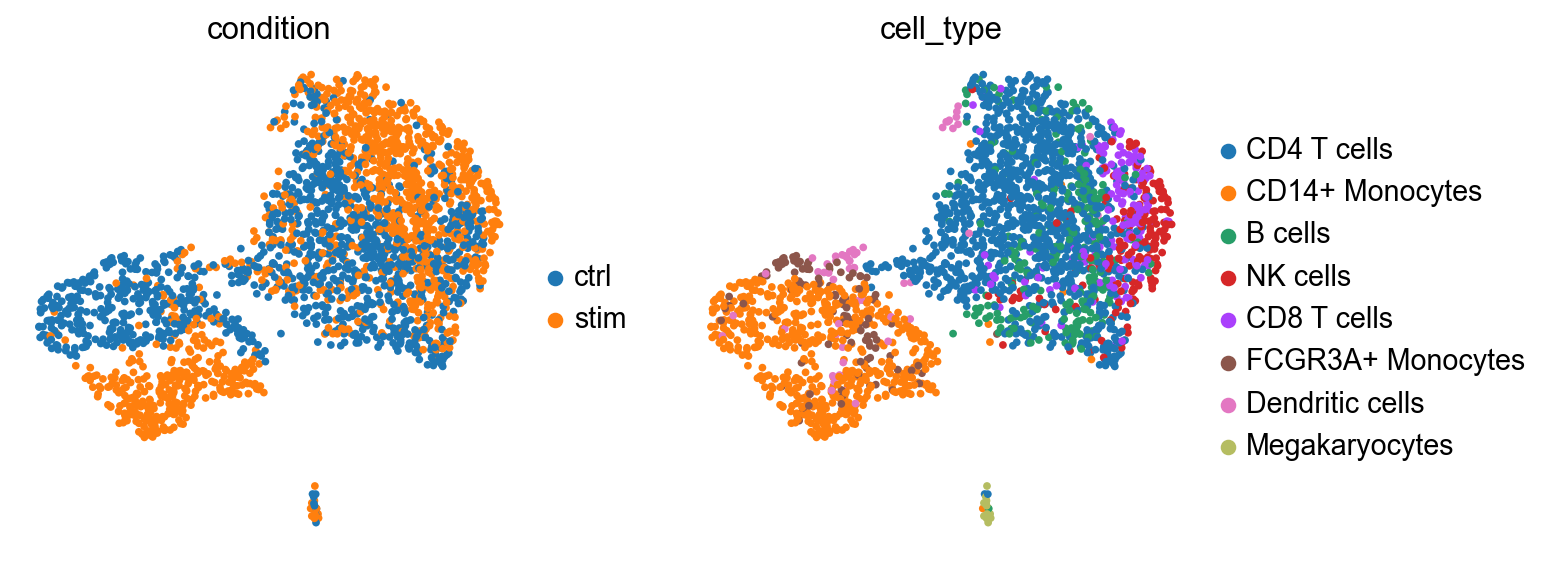

CPU times: total: 9.12 s
Wall time: 10.8 s


In [4]:
%%time

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["condition", "cell_type"], frameon=False, ncols=2)

In [9]:
print(adata)

AnnData object with n_obs × n_vars = 4934 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    uns: 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


## GSEA

#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [13]:
#Downloading reactome pathways.
from pathlib import Path

if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [5]:
#Prepare the result matrix for GSEA scores.
num_cells = adata.shape[0]
num_gene_sets = len(reactome['geneset'].unique())
gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

#Loop through each cell to run GSEA.
for cell_index in tqdm(range(num_cells)):
    #Get normalized expression values for the specific cell.
    cell_expr = adata.X[cell_index].toarray().flatten()
    
    #Create a DataFrame to hold DE scores.
    de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
    
    #Run GSEA using decoupler.
    _, norm, _ = decoupler.run_gsea(
        de_scores.T,
        reactome,
        source="geneset",
        target="genesymbol"
    )
    
    #Store the normalized enrichment scores (NES) in the result matrix.
    gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values

#Save the result matrix for later use.
np.save('./data/gsea_results_matrix.npy', gsea_results_matrix)

  0%|          | 0/4934 [00:00<?, ?it/s]

### Cluster With KMeans

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


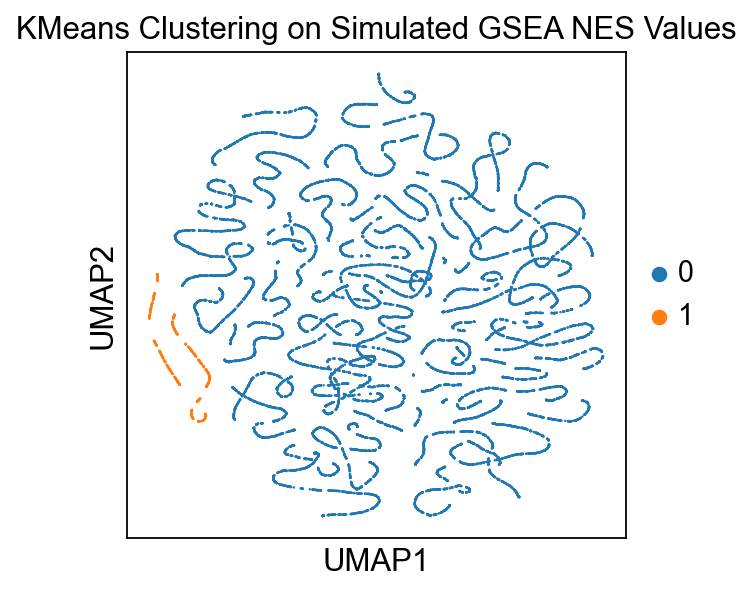

In [14]:
#Load the simulated GSEA results matrix.
gsea_results_matrix = np.load('./data/gsea_results_matrix.npy')

#Convert the result matrix to an AnnData object for visualization.
adata_gsea = sc.AnnData(X=gsea_results_matrix)
adata_gsea.var_names = [f'GeneSet_{i}' for i in range(gsea_results_matrix.shape[1])]
adata_gsea.obs_names = [f'Cell_{i}' for i in range(gsea_results_matrix.shape[0])]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(gsea_results_matrix)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(gsea_results_matrix)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata_gsea.obsm['X_umap'] = umap_coords
adata_gsea.obs['kmeans2'] = pd.Categorical(kmeans.labels_)

#Plot the UMAP with KMeans clustering results using Scanpy.
sc.pl.umap(adata_gsea, color=['kmeans2'], title='KMeans Clustering on Simulated GSEA NES Values')

### Cluster Results

 - Silhouette Score: This score measures how similar a point is to its own cluster compared to other clusters. The silhouette_score function from sklearn.metrics is used. Interpretation: The Silhouette score ranges from -1 to 1, where a higher value indicates better-defined clusters. A score close to 0 suggests that clusters are overlapping or poorly defined. A negative value, as in this case, typically indicates that data points might have been assigned to the wrong clusters. Given that your score is slightly negative, it suggests potential issues with cluster separability or consistency.
 - Calinski-Harabasz Index: This index evaluates the ratio of the sum of between-cluster dispersion and of within-cluster dispersion. The calinski_harabasz_score function from sklearn.metrics is used. Interpretation: The Calinski-Harabasz index, also known as the Variance Ratio Criterion, is used to assess cluster separation. Higher values indicate better-defined clusters. Your score is relatively high, suggesting that the clusters are well-separated in terms of variance, which contradicts the negative Silhouette score.
 - Dunn Index: This index is calculated by finding the minimum inter-cluster distance and dividing it by the maximum intra-cluster distance. The custom function dunn_index is used to compute this.
 Interpretation: The Dunn index evaluates cluster compactness and separation. Higher values are better, indicating well-separated and compact clusters. However, your Dunn index value is very low, suggesting poor separation and high intra-cluster distances.

In [16]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['X_umap']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.condition.map({'ctrl':0, 'stim':1})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)
'''
Silhouette Score: 0.06242213025689125
Calinski-Harabasz Index: 4.044869615938594
Dunn Index: 0.0002734548919755451
Special accuracy: 0.5135792460478313
'''

Silhouette Score: 0.15274816751480103
Calinski-Harabasz Index: 81.30104639410774


c:\Users\user\Documents\GitHub\PathSingle\notebooks\metrics.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w[y_pred[i], y_true[i]] += 1


Special accuracy: 0.5069914481416934
completeness score: 0.005095145831073995
homogeneity_score: 0.0009725928783938103
adjusted_mutual_info_score: 0.0015843371177709966
CPU times: total: 16.3 s
Wall time: 14.6 s


'\nSilhouette Score: 0.06242213025689125\nCalinski-Harabasz Index: 4.044869615938594\nDunn Index: 0.0002734548919755451\nSpecial accuracy: 0.5135792460478313\n'

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [4]:
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [5]:
decoupler.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running mlm on mat with 24673 samples and 15706 targets for 14 sources.


100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


### Cluster With KMeans

Pathway activity matrix shape: (24673, 14)


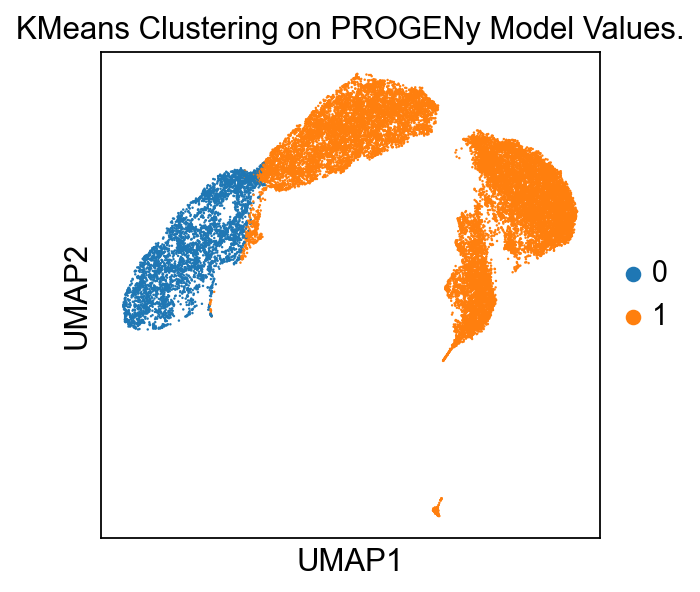

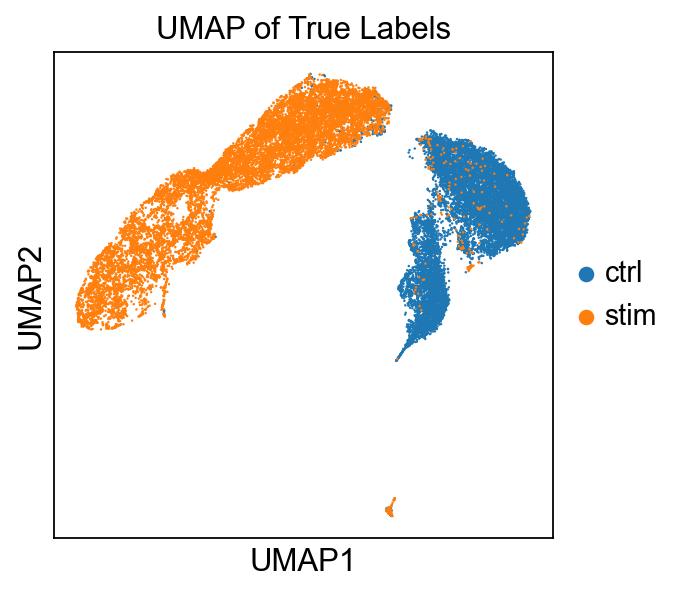

In [6]:
acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")
sc.pl.umap(adata, color=["condition"], title="UMAP of True Labels")

### Cluster Results

In [11]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.condition.map({'ctrl':0, 'stim':1})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)
'''
Silhouette Score: 0.5741430521011353
Calinski-Harabasz Index: 56256.505368459
Dunn Index: 0.04622566035103979

Silhouette Score: 0.6395565867424011
Calinski-Harabasz Index: 7904.9501393176015
Dunn Index: 0.01524794752580094
Special accuracy: 0.674098094852047

Silhouette Score: 0.7588374018669128
Calinski-Harabasz Index: 14997.468796563991
Dunn Index: 0.02165433133599389
Special accuracy: 0.6291041751114714
'''

Silhouette Score: 0.635316014289856
Calinski-Harabasz Index: 39274.03848703759


c:\Users\user\Documents\GitHub\PathSingle\notebooks\metrics.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w[y_pred[i], y_true[i]] += 1


Special accuracy: 0.6857293397641147
completeness score: 0.30868460757831095
homogeneity_score: 0.21469362078133267
adjusted_mutual_info_score: 0.2532236619982422
CPU times: total: 20.1 s
Wall time: 14 s


'\nSilhouette Score: 0.5741430521011353\nCalinski-Harabasz Index: 56256.505368459\nDunn Index: 0.04622566035103979\nCPU times: total: 30.8 s\nWall time: 1min 12s\n\nSilhouette Score: 0.6395565867424011\nCalinski-Harabasz Index: 7904.9501393176015\nDunn Index: 0.01524794752580094\nSpecial accuracy: 0.674098094852047\n\nSilhouette Score: 0.7588374018669128\nCalinski-Harabasz Index: 14997.468796563991\nDunn Index: 0.02165433133599389\nSpecial accuracy: 0.6291041751114714\n'

## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [19]:
%%time
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
    verbose=True
)
adata

Running aucell on mat with 24673 samples and 15706 targets for 1457 sources.


100%|██████████| 24673/24673 [08:48<00:00, 46.70it/s]

CPU times: total: 6min 32s
Wall time: 8min 51s


AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    uns: 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'aucell_estimate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Cluster With KMeans

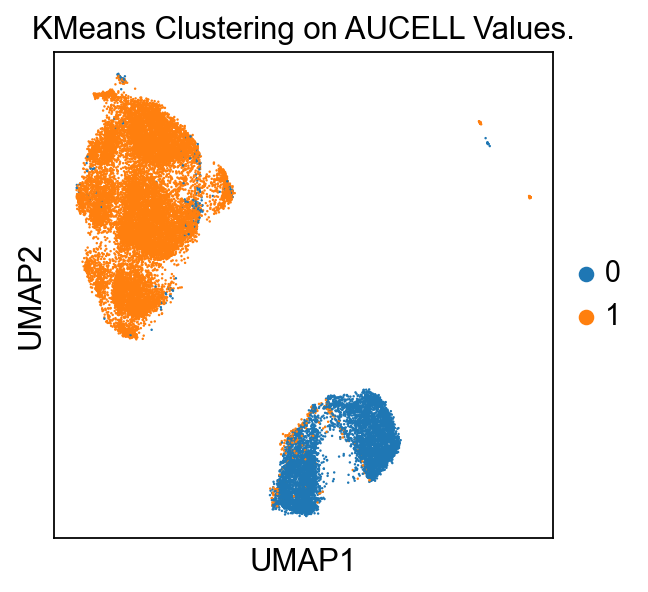

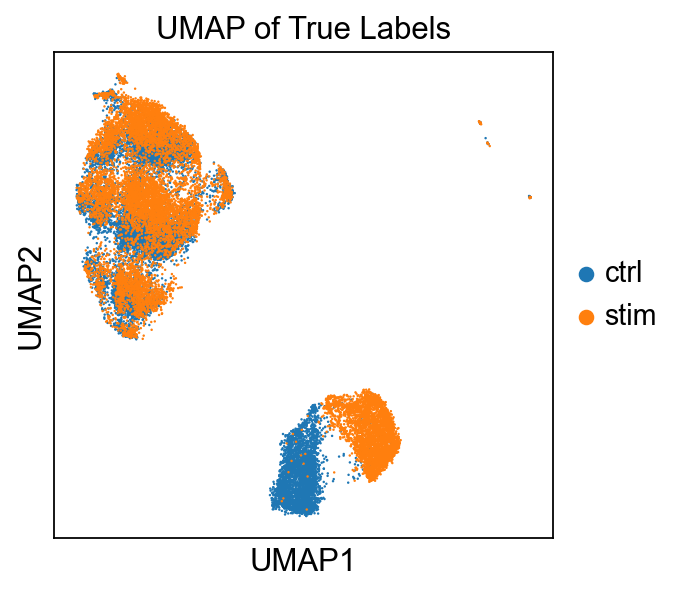

In [20]:
#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = adata.obsm["aucell_estimate"]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15)
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans4'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans4"], title="KMeans Clustering on AUCELL Values.")
sc.pl.umap(adata, color=["condition"], title="UMAP of True Labels")

### Cluster Results

In [21]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['aucell_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.condition.map({'ctrl':0, 'stim':1})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)
'''
Silhouette Score: 0.13764698803424835
Calinski-Harabasz Index: 3215.894450359765
Dunn Index: 0.2627693665418968
'''

Silhouette Score: 0.13764698803424835
Calinski-Harabasz Index: 3215.894450359765


c:\Users\user\Documents\GitHub\PathSingle\notebooks\metrics.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w[y_pred[i], y_true[i]] += 1


Special accuracy: 0.5055728934462773
completeness score: 0.00014320899703728832
homogeneity_score: 0.0001241064534269903
adjusted_mutual_info_score: 0.00010165028332201413
CPU times: total: 2min
Wall time: 30.8 s


'\nSilhouette Score: 0.13764698803424835\nCalinski-Harabasz Index: 3215.894450359765\nDunn Index: 0.2627693665418968\n'

## PathSingle

### Run Magic

In [11]:
# We prefer using rawcounts for magic imputation.
#adata.X = adata.layers['counts'].copy()
activity_df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
#activity_df = scprep.normalize.library_size_normalize(activity_df)
#activity_df = scprep.transform.sqrt(activity_df)

magic_op = magic.MAGIC()
activity_df = magic_op.fit_transform(activity_df)
activity_df.to_csv('./data/activity_df.csv', index=True)

Calculating MAGIC...
  Running MAGIC on 2467 cells and 15706 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.59 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
    Calculated affinities in 0.50 seconds.
  Calculated graph and diffusion operator in 2.72 seconds.
  Running MAGIC with `solver='exact'` on 15706-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.39 seconds.
Calculated MAGIC in 5.23 seconds.


### Run PathSingle

In [14]:
activity = sc.read('./data/activity_df.csv', delimiter=',', cache=False)
calc_activity(activity)

AnnData object with n_obs × n_vars = 2467 × 15706


100%|██████████| 494/494 [22:53<00:00,  2.78s/it]


### Cluster With KMeans

In [ ]:
bdata = sc.read('./data/output_activity.csv', delimiter=',')

#Scale the data.
scaler = StandardScaler()
bdata.X = scaler.fit_transform(bdata.X)

#Perform PCA for Dimensionality Reduction.
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

#Perform KMeans clustering.
kmeans = KMeans(n_clusters=2, random_state=0).fit(bdata.X)
bdata.obs['kmeans'] = pd.Categorical(kmeans.labels_)

#Perform PCA and UMAP.
#umap_model = umap.UMAP(n_neighbors=15, random_state=0)
#umap_coords = umap_model.fit_transform(df)
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=30, n_pcs=50)
sc.tl.umap(bdata, min_dist=0.3)

#Add the UMAP coordinates and clustering results to the AnnData object.
#bdata.obs['X_umap'] = bdata.obsm['X_umap']
#adata.obs['kmeans4'] = pd.Categorical(kmeans.labels_)

#Add the true labels from the original 'adata'.
#bdata.obs['condition'] = adata.obs['condition']
cell_state = adata.obs['condition']
bdata.obs['condition'] = cell_state[emt_magic.index].values

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(bdata, color=["kmeans"], title="KMeans Clustering on PathSingle Values.")
sc.pl.umap(bdata, color=["condition"], title="UMAP of True Labels")

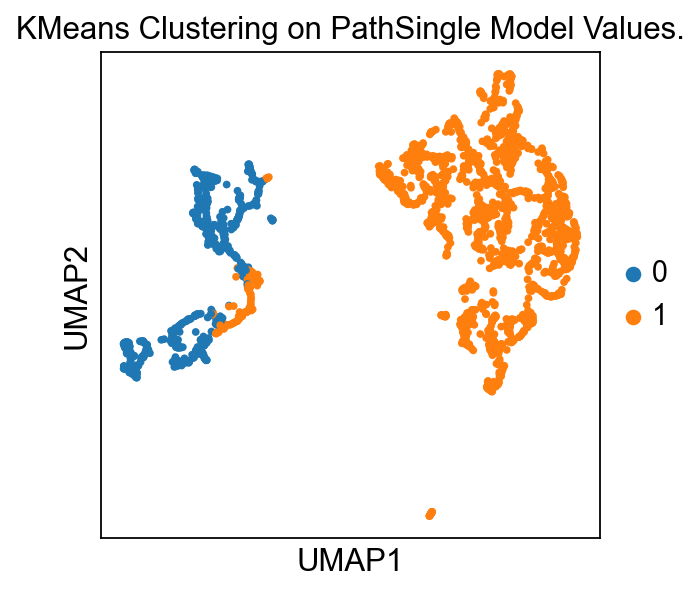

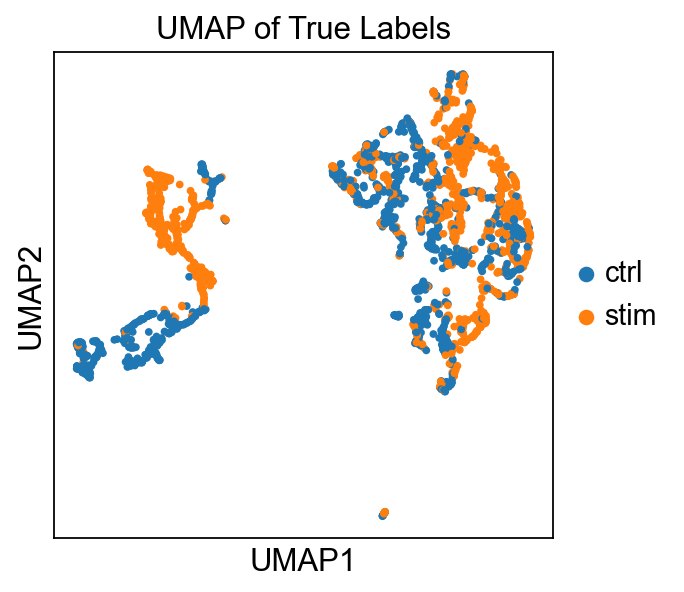

In [18]:
from sklearn.decomposition import PCA


output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

#Scale the data.
scaler = StandardScaler()
output_activity = scaler.fit_transform(output_activity)
PCA = PCA(n_components=50, svd_solver='arpack')
output_activty = PCA.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(output_activity)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)
cell_state = adata.obs['condition']
#cdata.obs['state'] = cell_state[emt_magic.index].values

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PathSingle Model Values.")
sc.pl.umap(adata, color=["condition"], title="UMAP of True Labels")

### Cluster Results

In [19]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.condition.map({'ctrl':0, 'stim':1})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)
'''
Silhouette Score: 0.3299906551837921
Calinski-Harabasz Index: 7361.734349622491
Dunn Index: 0.02108178870064121
0.5016009402991124

Silhouette Score: 0.43027883768081665
Calinski-Harabasz Index: 15094.000534262332
Dunn Index: 0.030910595645710495
0.5042759291533255

Silhouette Score: 0.5255643129348755
Calinski-Harabasz Index: 3859.402240364315
Dunn Index: 0.02282853897549874
Special accuracy: 0.5020267531414674

Silhouette Score: 0.3935227394104004
Calinski-Harabasz Index: 922.9809794940934
Dunn Index: 0.2553697007099271
Special accuracy: 0.522740696987596

Silhouette Score: 0.563823646025838
Calinski-Harabasz Index: 2785.9250868677827
Special accuracy: 0.5022294284556141
completeness score: 7.513792057228478e-06
homogeneity_score: 5.817606581201096e-06
adjusted_mutual_info_score: -0.00032350134218196236
'''

Silhouette Score: 0.3494242484061349
Calinski-Harabasz Index: 907.4838150810418
Special accuracy: 0.5111471422780706
completeness score: 0.0003060058292290838
homogeneity_score: 0.0002461480006299037
adjusted_mutual_info_score: -5.1607621437885244e-05
CPU times: total: 7.56 s
Wall time: 2.65 s


c:\Users\user\Documents\GitHub\PathSingle\notebooks\metrics.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w[y_pred[i], y_true[i]] += 1


'\nSilhouette Score: 0.3299906551837921\nCalinski-Harabasz Index: 7361.734349622491\nDunn Index: 0.02108178870064121\n0.5016009402991124\n\nSilhouette Score: 0.43027883768081665\nCalinski-Harabasz Index: 15094.000534262332\nDunn Index: 0.030910595645710495\n0.5042759291533255\n\nSilhouette Score: 0.5255643129348755\nCalinski-Harabasz Index: 3859.402240364315\nDunn Index: 0.02282853897549874\nSpecial accuracy: 0.5020267531414674\n\nSilhouette Score: 0.3935227394104004\nCalinski-Harabasz Index: 922.9809794940934\nDunn Index: 0.2553697007099271\nSpecial accuracy: 0.522740696987596\n\nSilhouette Score: 0.563823646025838\nCalinski-Harabasz Index: 2785.9250868677827\nSpecial accuracy: 0.5022294284556141\ncompleteness score: 7.513792057228478e-06\nhomogeneity_score: 5.817606581201096e-06\nadjusted_mutual_info_score: -0.00032350134218196236\n'

## Session info

In [43]:
session_info.show()

### References

https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.html

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html